# Goal
### Create suitable categorical variables, choose most significant variables, choose two prediction models and and pick the best one

In [14]:
import seaborn as sns

In [15]:
import pandas as pd; pd.set_option('display.max_columns', 1000); pd.set_option('display.max_rows', 1000) ; pd.set_option('display.width', 1000)
import numpy as np
#import the cleaned and preprocessed data ready for prediction analysis
san_fran_df = pd.read_csv('data_for_prediction.csv')
san_fran_df = san_fran_df.drop('geometry', axis=1)
san_fran_df

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration        idle_time station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label
0        2018-01-01 00:01:53  2018-01-01 03:50:23                86          37.769305        -122.426826             119        37.761047      -122.432642     2924  0 days 03:48:30              NaN   0 days 00:01:53               14.0             12.0               28.0             27.0                 Mostly Cloudy               Mostly Cloudy          1018.6       1019.96              6.0            0.0                  0.0                0.0                    14.0                  12.0        0           0              2.0                         4           0          1.050128           2
1        2018-01-01 00:07:52  2018-01-01 00:19:47                74          37.776435        -122.426244              70        37.773311      -122.444293     2423  0 days 00:11:55              NaN   0 days 00:07:52               14.0             14.0               28.0             28.0                 Mostly Cloudy               Mostly Cloudy          1018.6       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        0           0              0.0                         3           0          1.627451           2
2        2018-01-01 00:09:31  2018-01-01 00:28:43                97          37.768265        -122.420110             125        37.759200      -122.409851     3455  0 days 00:19:12              NaN   0 days 00:09:31               14.0             14.0               28.0             28.0                 Mostly Cloudy               Mostly Cloudy          1018.6       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        0           0              0.0                         3           0          1.352513           2
3        2018-01-01 00:14:37  2018-01-01 00:37:16                11          37.797280        -122.398436             323        37.798014      -122.405950     2173  0 days 00:22:39              NaN   0 days 00:14:37               14.0             14.0               28.0             28.0                 Mostly Cloudy               Mostly Cloudy          1018.6       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        0           0              0.0                         3           0          0.666811           2
4        2018-01-01 00:15:26  2018-01-01 05:08:01                55          37.777053        -122.429558             285        37.783521      -122.431158     2315  0 days 04:52:35              NaN   0 days 00:15:26               14.0             12.0               28.0             27.0                 Mostly Cloudy               Mostly Cloudy          1018.6       1020.63              6.0            6.0                  0.0                0.0                    14.0                  12.0        0           0              2.0                         4           0          0.731608           2
...                      ...                  ...               ...                ...                ...             ...              ...              ...      ...              ...              ...               ...                ...              ...                ...              ...                           ...                         ...             ...           ...              ...            ...    

In [16]:
import mapclassify
from geopy.distance import geodesic

In [17]:
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
sns.set_style("white")

## create a new column idle_time_end
For the purpose of prediction of idle_time it makes more sense to include the idle_time of a bike in the column where the bike trip preceding the idle_time has been recorded. 

This will make it possible to directly examine the features such as weather at time of drop off, end_time or end_station_id.

In [18]:
san_fran_df['idle_time']

0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
                ...       
1362596    0 days 07:55:32
1362597    0 days 03:25:11
1362598    0 days 12:03:05
1362599    0 days 12:16:27
1362600    0 days 11:49:44
Name: idle_time, Length: 1362601, dtype: object

In [19]:
#sort the dataframe by bike id and start time
san_fran_df.sort_values(['bike_id', 'start_time'], inplace=True)
san_fran_df

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration        idle_time station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label
1160     2018-01-02 07:32:44  2018-01-02 07:44:36                60          37.774520        -122.409449             324        37.788300      -122.408531       17  0 days 00:11:52              NaN   1 days 07:32:44               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.65       1021.65              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.531567           2
1735     2018-01-02 09:17:14  2018-01-02 09:23:41               324          37.788300        -122.408531              37        37.785000      -122.395936       17  0 days 00:06:27  0 days 01:32:38   0 days 13:09:25               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.31       1021.31              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.168362           2
3554     2018-01-03 05:13:20  2018-01-03 05:15:55                37          37.785000        -122.395936              21        37.789625      -122.400811       17  0 days 00:02:35  0 days 19:49:39   0 days 00:00:00               14.0             14.0               26.0             26.0                        Cloudy                      Cloudy         1018.60       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        2           0              0.0                         3           0          0.669345           2
4775     2018-01-03 12:49:30  2018-01-03 13:11:05                53          37.775946        -122.437777               5        37.783899      -122.408445       17  0 days 00:21:35  0 days 07:33:35   0 days 00:00:00               12.0             12.0               27.0             27.0                 Mostly Cloudy               Mostly Cloudy         1016.57       1016.57              6.0            6.0                  0.0                0.0                    12.0                  12.0        2           0              0.0                         3           0          2.730661           2
5025     2018-01-03 16:21:24  2018-01-03 16:26:19                 5          37.783899        -122.408445              25        37.787522      -122.397405       17  0 days 00:04:55  0 days 03:10:19   0 days 06:49:53               11.0             12.0               28.0             26.0                 Mostly Cloudy                      Cloudy         1016.23       1016.57              0.0            7.0                  0.0                0.0                    11.0                  12.0        2           0             -1.0                         2           0          1.052319           2
...                      ...                  ...               ...                ...                ...             ...              ...              ...      ...              ...              ...               ...                ...              ...                ...              ...                           ...                         ...             ...           ...              ...            ...    

We have a look at the first bike:

In [21]:
bike17 = san_fran_df[san_fran_df['bike_id']==17]
bike17

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration         idle_time  station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label
1160     2018-01-02 07:32:44  2018-01-02 07:44:36                60          37.774520        -122.409449             324        37.788300      -122.408531       17  0 days 00:11:52               NaN    1 days 07:32:44               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.65       1021.65              6.0            6.0                 0.00               0.00                    12.0                  12.0        1           0              0.0                         3           0          1.531567           2
1735     2018-01-02 09:17:14  2018-01-02 09:23:41               324          37.788300        -122.408531              37        37.785000      -122.395936       17  0 days 00:06:27   0 days 01:32:38    0 days 13:09:25               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.31       1021.31              6.0            6.0                 0.00               0.00                    12.0                  12.0        1           0              0.0                         3           0          1.168362           2
3554     2018-01-03 05:13:20  2018-01-03 05:15:55                37          37.785000        -122.395936              21        37.789625      -122.400811       17  0 days 00:02:35   0 days 19:49:39    0 days 00:00:00               14.0             14.0               26.0             26.0                        Cloudy                      Cloudy         1018.60       1018.60              6.0            6.0                 0.00               0.00                    14.0                  14.0        2           0              0.0                         3           0          0.669345           2
4775     2018-01-03 12:49:30  2018-01-03 13:11:05                53          37.775946        -122.437777               5        37.783899      -122.408445       17  0 days 00:21:35   0 days 07:33:35    0 days 00:00:00               12.0             12.0               27.0             27.0                 Mostly Cloudy               Mostly Cloudy         1016.57       1016.57              6.0            6.0                 0.00               0.00                    12.0                  12.0        2           0              0.0                         3           0          2.730661           2
5025     2018-01-03 16:21:24  2018-01-03 16:26:19                 5          37.783899        -122.408445              25        37.787522      -122.397405       17  0 days 00:04:55   0 days 03:10:19    0 days 06:49:53               11.0             12.0               28.0             26.0                 Mostly Cloudy                      Cloudy         1016.23       1016.57              0.0            7.0                 0.00               0.00                    11.0                  12.0        2           0             -1.0                         2           0          1.052319           2
5063     2018-01-03 16:38:29  2018-01-03 16:46:13                25          37.787522        -122.397405              30        37.776598      -122.395282       17  0 days 00:07:44   0 days 00:12:10    0 days 08:01:48               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1016.57       1016.57              7.0     

This shows us that the idle_time is in the row of the next rental, we now want to shift the row to the one were the trip has ended.

We can do this because the dataframe is grouped by bike id and sorted chronologicaly in those groups.

As a result each last rental of the year for every bike_id will have an NaN value.

In [22]:
#perform the shift
san_fran_df['idle_time'] =  san_fran_df['idle_time'].shift(-1)

In [23]:
#check that the shift has worked
bike17 = san_fran_df[san_fran_df['bike_id']==17]
bike17

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration         idle_time  station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label
1160     2018-01-02 07:32:44  2018-01-02 07:44:36                60          37.774520        -122.409449             324        37.788300      -122.408531       17  0 days 00:11:52   0 days 01:32:38    1 days 07:32:44               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.65       1021.65              6.0            6.0                 0.00               0.00                    12.0                  12.0        1           0              0.0                         3           0          1.531567           2
1735     2018-01-02 09:17:14  2018-01-02 09:23:41               324          37.788300        -122.408531              37        37.785000      -122.395936       17  0 days 00:06:27   0 days 19:49:39    0 days 13:09:25               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.31       1021.31              6.0            6.0                 0.00               0.00                    12.0                  12.0        1           0              0.0                         3           0          1.168362           2
3554     2018-01-03 05:13:20  2018-01-03 05:15:55                37          37.785000        -122.395936              21        37.789625      -122.400811       17  0 days 00:02:35   0 days 07:33:35    0 days 00:00:00               14.0             14.0               26.0             26.0                        Cloudy                      Cloudy         1018.60       1018.60              6.0            6.0                 0.00               0.00                    14.0                  14.0        2           0              0.0                         3           0          0.669345           2
4775     2018-01-03 12:49:30  2018-01-03 13:11:05                53          37.775946        -122.437777               5        37.783899      -122.408445       17  0 days 00:21:35   0 days 03:10:19    0 days 00:00:00               12.0             12.0               27.0             27.0                 Mostly Cloudy               Mostly Cloudy         1016.57       1016.57              6.0            6.0                 0.00               0.00                    12.0                  12.0        2           0              0.0                         3           0          2.730661           2
5025     2018-01-03 16:21:24  2018-01-03 16:26:19                 5          37.783899        -122.408445              25        37.787522      -122.397405       17  0 days 00:04:55   0 days 00:12:10    0 days 06:49:53               11.0             12.0               28.0             26.0                 Mostly Cloudy                      Cloudy         1016.23       1016.57              0.0            7.0                 0.00               0.00                    11.0                  12.0        2           0             -1.0                         2           0          1.052319           2
5063     2018-01-03 16:38:29  2018-01-03 16:46:13                25          37.787522        -122.397405              30        37.776598      -122.395282       17  0 days 00:07:44   0 days 02:25:33    0 days 08:01:48               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1016.57       1016.57              7.0     

In [24]:
#look at the the whole dataframe
san_fran_df

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration        idle_time station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label
1160     2018-01-02 07:32:44  2018-01-02 07:44:36                60          37.774520        -122.409449             324        37.788300      -122.408531       17  0 days 00:11:52  0 days 01:32:38   1 days 07:32:44               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.65       1021.65              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.531567           2
1735     2018-01-02 09:17:14  2018-01-02 09:23:41               324          37.788300        -122.408531              37        37.785000      -122.395936       17  0 days 00:06:27  0 days 19:49:39   0 days 13:09:25               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.31       1021.31              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.168362           2
3554     2018-01-03 05:13:20  2018-01-03 05:15:55                37          37.785000        -122.395936              21        37.789625      -122.400811       17  0 days 00:02:35  0 days 07:33:35   0 days 00:00:00               14.0             14.0               26.0             26.0                        Cloudy                      Cloudy         1018.60       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        2           0              0.0                         3           0          0.669345           2
4775     2018-01-03 12:49:30  2018-01-03 13:11:05                53          37.775946        -122.437777               5        37.783899      -122.408445       17  0 days 00:21:35  0 days 03:10:19   0 days 00:00:00               12.0             12.0               27.0             27.0                 Mostly Cloudy               Mostly Cloudy         1016.57       1016.57              6.0            6.0                  0.0                0.0                    12.0                  12.0        2           0              0.0                         3           0          2.730661           2
5025     2018-01-03 16:21:24  2018-01-03 16:26:19                 5          37.783899        -122.408445              25        37.787522      -122.397405       17  0 days 00:04:55  0 days 00:12:10   0 days 06:49:53               11.0             12.0               28.0             26.0                 Mostly Cloudy                      Cloudy         1016.23       1016.57              0.0            7.0                  0.0                0.0                    11.0                  12.0        2           0             -1.0                         2           0          1.052319           2
...                      ...                  ...               ...                ...                ...             ...              ...              ...      ...              ...              ...               ...                ...              ...                ...              ...                           ...                         ...             ...           ...              ...            ...    

# Choosing the most relevant features for the predictive model

## POI features

We will make use of the POI csv file for calculating distances from stations.

In [25]:
#importing POI data
north_cali_loc = pd.read_csv('NorthernCalifornia_POIs', low_memory=False)
north_cali_loc = north_cali_loc.drop('geometry', axis=1)
pois_df = gpd.GeoDataFrame(north_cali_loc, geometry=gpd.points_from_xy(north_cali_loc['lon'], north_cali_loc['lat']))

In [26]:
pois_df.head()

Unnamed: 0  version   timestamp  changeset        id                                               tags        lat        lon addr:city addr:country addr:full addr:housenumber addr:housename addr:postcode addr:place addr:street email                       name opening_hours operator phone  ref  url website  amenity  atm bank bicycle_parking bicycle_rental  bar building building:levels cafe car_wash drinking_water fast_food fountain fuel gambling ice_cream internet_access kindergarten landuse library office parking police school social_facility     source start_date theatre university wikipedia agrarian alcohol bakery bicycle books  car clothes coffee collector computer cosmetics craft dry_cleaning fireplace furniture  gas hairdresser kiosk kitchen lottery massage medical_supply model motorcycle music musical_instrument organic outdoor  pet religion second_hand shoes shop  ski supermarket trade video water wholesale wine attraction camp_site guest_house information museum  \
0           0        3  1567817615        0.0  15972546  {"brand":"Chase","brand:wikidata":"Q524629","b...  36.979366 -122.02073       NaN          NaN       NaN              NaN            NaN           NaN        NaN         NaN   NaN                      Chase           NaN      NaN   NaN  NaN  NaN     NaN     bank  NaN  NaN             NaN            NaN  NaN      NaN             NaN  NaN      NaN            NaN       NaN      NaN  NaN      NaN       NaN             NaN          NaN     NaN     NaN    NaN     NaN    NaN    NaN             NaN        NaN        NaN     NaN        NaN       NaN      NaN     NaN    NaN     NaN   NaN  NaN     NaN    NaN       NaN      NaN       NaN   NaN          NaN       NaN       NaN  NaN         NaN   NaN     NaN     NaN     NaN            NaN   NaN        NaN   NaN                NaN     NaN     NaN  NaN      NaN         NaN   NaN  NaN  NaN         NaN   NaN   NaN   NaN       NaN  NaN        NaN       NaN         NaN         NaN    NaN   
1           1        9  1511822788        0.0  26637661  {"direction":"45-112","ele":"1343","name:zh":"...  37.715797 -119.67690       NaN          NaN       NaN              NaN            NaN           NaN        NaN         NaN   NaN                Tunnel View           NaN      NaN   NaN  NaN  NaN     NaN      NaN  NaN  NaN             NaN            NaN  NaN      NaN             NaN  NaN      NaN            NaN       NaN      NaN  NaN      NaN       NaN             NaN          NaN     NaN     NaN    NaN     NaN    NaN    NaN             NaN  USGS Topo        NaN     NaN        NaN       NaN      NaN     NaN    NaN     NaN   NaN  NaN     NaN    NaN       NaN      NaN       NaN   NaN          NaN       NaN       NaN  NaN         NaN   NaN     NaN     NaN     NaN            NaN   NaN        NaN   NaN                NaN     NaN     NaN  NaN      NaN         NaN   NaN  NaN  NaN         NaN   NaN   NaN   NaN       NaN  NaN        NaN       NaN         NaN         NaN    NaN   
2           2        5  1413753424        0.0  29946571                                {"access":"public"}  40.685482 -121.41899       NaN          NaN       NaN              NaN            NaN           NaN        NaN         NaN   NaN                        NaN           NaN      NaN   NaN  NaN  NaN     NaN  toilets  NaN  NaN             NaN            NaN  NaN      NaN             NaN  NaN      NaN            NaN       NaN      NaN  NaN      NaN       NaN             NaN          NaN     NaN     NaN    NaN     NaN    NaN    NaN             NaN        NaN        NaN     NaN        NaN       NaN      NaN     NaN    NaN     NaN   NaN  NaN     NaN    NaN       NaN      NaN       NaN   NaN          NaN       NaN       NaN  NaN         NaN   NaN     NaN     NaN     NaN            NaN   NaN        NaN   NaN                NaN     NaN     NaN  NaN      NaN         NaN   NaN  NaN  NaN         NaN   NaN   NaN   NaN       NaN  NaN        NaN       NaN         NaN         NaN    NaN   
3           3        1  1190872143 

In [27]:
pois_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 206875 entries, 0 to 206874
Columns: 114 entries, Unnamed: 0 to geometry
dtypes: float64(3), geometry(1), int64(3), object(107)
memory usage: 179.9+ MB


In [28]:
#drop useless columns in pois_df
columns_to_drop = ['Unnamed: 0','tags', 'operator', 'phone', 'ref', 'url', 'website', 'addr:city', 'addr:country', 'addr:full','addr:housenumber', 'addr:housename', 'addr:postcode', 'addr:place', 'addr:street', 'email']
pois_df = pois_df.drop(columns_to_drop,axis=1)

In [29]:
#show all names od POIs for easy searching by name using ctrl+F
name = pois_df['name'].unique().tolist()
print(name)



['Chase', 'Tunnel View', nan, "Captain Jack's Stronghold", 'Fleener Chimneys', 'The Rock', 'Big Painted Cave Trail Parking', 'Schonchin Butte Parking', 'Declaring Peace Through All Our Relations', 'Gillespie Youth Camp', 'Lava Beds Visitor Center', 'Hospital Rock', 'Gillems Camp', 'Canby Cross', 'Wildlife Overlook', 'Thomas-Wright Battlefield', 'Black Crater', 'Devils Homestead Overlook', 'Heppe Cave', 'Mammoth Crater', 'Hidden Valley', 'Garden Bridges', 'Indian Well Campground', 'Bunchgrass Overlook', 'Woods Lowside', 'Toronado', "Molotov's", 'Noc Noc', 'Danny Coyles', 'The Page', "Martuni's", "Hobson's Choice", 'Magnolia Pub & Brewery', 'The Gold Cane', 'Club Deluxe', 'Trax', 'Aub Zam Zam', 'United States Post Office - Gateway Station', 'Comstock Saloon', "Mr. Bing's", 'Irish Times', 'Old Ship Saloon', "Dragon's Gate", 'Nancy Brown Kantz', 'Fitzgerald Marine Reserve', 'Rotary Peace Grove', 'Hidden Valley Trailhead', 'College of the Redwoods - Eureka Campus', 'Tish Tang Trailhead', 'C

In [30]:
#look up all unique values in column 'amenity'
amenity = pois_df['amenity'].unique().tolist()
print(amenity)

['bank', nan, 'toilets', 'drinking_water', 'parking', 'bench', 'pub', 'bar', 'post_box', 'post_office', 'parking_entrance', 'school', 'weighbridge', 'bus_station', 'cinema', 'trailer_park', 'restaurant', 'atm', 'ranger_station', 'fast_food', 'fuel', 'pharmacy', 'fire_station', 'place_of_worship', 'fountain', 'recycling', 'police', 'ferry_terminal', 'prison', 'telephone', 'cafe', 'bicycle_parking', 'veterinary', 'community_centre', 'nightclub', 'townhall', 'library', 'clock', 'ice_cream', 'clinic', 'theatre', 'doctors', 'car_rental', 'prep_school', 'dentist', 'winery', 'toilets_closed', 'shelter', 'animal_boarding', 'car_wash', 'music_venue', 'grave_yard', 'kindergarten', 'college', 'university', 'language_school', 'nursing_home', 'hospital', 'social_facility', 'Residential care facility', 'studio', 'social_centre', 'public_building', 'arts_centre', 'courthouse', 'planetarium', 'waste_basket', 'loading_dock', 'taxi', 'car_sharing', 'waste_container', 'vending_machine', 'bicycle_rental',

The process that brought us to choose the following points of interest has been driven by the visual analysis made on the usage volume of Bike Stations located in a radius of 400m from our POI.

## King street station

King street central station is one of our first potential POIs that we could use for predicting the idle_time.

Located just south of Market Street, this station represents one of the most relevant points for bikes drop off and pick up, displaying all the point of interest in this area we found the Tahoe Convoy bus station that can be considered as our POI for summing up the bike sharing volume of this area of the city.
Supporting this POI decision is the presence of three of the most used Bike Stations in all of San Francisco, station 81 and station 30 and station 67.



In [31]:
# we use the coordinates of the Tahoe Convoy bus station as a placeholder of the coordinates for the King street station
central_station = pois_df[pois_df['name'] == 'Tahoe Convoy']
central_station




version   timestamp  changeset          id        lat        lon          name opening_hours      amenity  atm bank bicycle_parking bicycle_rental  bar building building:levels cafe car_wash drinking_water fast_food fountain fuel gambling ice_cream internet_access kindergarten landuse library office parking police school social_facility source start_date theatre university wikipedia agrarian alcohol bakery bicycle books  car clothes coffee collector computer cosmetics craft dry_cleaning fireplace furniture  gas hairdresser kiosk kitchen lottery massage medical_supply model motorcycle music musical_instrument organic outdoor  pet religion second_hand shoes shop  ski supermarket trade video water wholesale wine attraction camp_site guest_house information museum tourism viewpoint  zoo osm_type  bbq restaurant social_centre caravan deli golf laundry swimming_pool trailer tyres                     geometry
79303        2  1617944594        0.0  8418786287  37.775352 -122.39713  Tahoe Convoy           NaN  bus_station  NaN  NaN             NaN            NaN  NaN      NaN             NaN  NaN      NaN            NaN       NaN      NaN  NaN      NaN       NaN             NaN          NaN     NaN     NaN    NaN     NaN    NaN    NaN             NaN    NaN        NaN     NaN        NaN       NaN      NaN     NaN    NaN     NaN   NaN  NaN     NaN    NaN       NaN      NaN       NaN   NaN          NaN       NaN       NaN  NaN         NaN   NaN     NaN     NaN     NaN            NaN   NaN        NaN   NaN                NaN     NaN     NaN  NaN      NaN         NaN   NaN  NaN  NaN         NaN   NaN   NaN   NaN       NaN  NaN        NaN       NaN         NaN         NaN    NaN     NaN       NaN  NaN     node  NaN        NaN           NaN     NaN  NaN  NaN     NaN           NaN     NaN   NaN  POINT (-122.39713 37.77535)

We define a new function that will calculate the distance of the a station in kilometers from the chosen POI. 

In [33]:
def calculate_distance(row, lat, lon, central_station):
    location = (row[lat], row[lon])
    target_location = (central_station['lat'], central_station['lon'])
    return geodesic(location, target_location).kilometers

central_station = {'lat': 37.775352, 'lon': -122.39713}
#we will not let this run due to time constraints
"""
san_fran_df['end_station_central_station_dist'] = san_fran_df.apply(lambda row: calculate_distance(row, 'end_station_lat', 'end_station_lon', central_station), axis=1)
"""
print()

We are interested in the distance of the end_station from a chosen POI. The assumptions is that the idle_time will be influenced by/dependent on the how far the station is located from a point of interest.

## Twitter HQ
for comparison we will also choose more random point from the map where there also was a lot of rentals (only at one station), such as a place in the vicinity of the Twitter HQ.

In [34]:
twitter_HQ = {"lat": 37.7767414, "lon": -122.4165504}
#we will not let this run due to time constraints
"""
san_fran_df['end_station_twitter_HQ_dist'] = san_fran_df.apply(lambda row: calculate_distance(row, 'end_station_lat', 'end_station_lon', twitter_HQ), axis=1)
"""

In [35]:
#check if a new column has been added
san_fran_df.head()

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration        idle_time station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label  end_station_central_station_dist  end_station_twitter_HQ_dist
1160  2018-01-02 07:32:44  2018-01-02 07:44:36                60          37.774520        -122.409449             324        37.788300      -122.408531       17  0 days 00:11:52  0 days 01:32:38   1 days 07:32:44               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.65       1021.65              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.531567           2                          1.753276                     1.464568
1735  2018-01-02 09:17:14  2018-01-02 09:23:41               324          37.788300        -122.408531              37        37.785000      -122.395936       17  0 days 00:06:27  0 days 19:49:39   0 days 13:09:25               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.31       1021.31              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.168362           2                          1.075981                     2.034235
3554  2018-01-03 05:13:20  2018-01-03 05:15:55                37          37.785000        -122.395936              21        37.789625      -122.400811       17  0 days 00:02:35  0 days 07:33:35   0 days 00:00:00               14.0             14.0               26.0             26.0                        Cloudy                      Cloudy         1018.60       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        2           0              0.0                         3           0          0.669345           2                          1.617083                     1.991816
4775  2018-01-03 12:49:30  2018-01-03 13:11:05                53          37.775946        -122.437777               5        37.783899      -122.408445       17  0 days 00:21:35  0 days 03:10:19   0 days 00:00:00               12.0             12.0               27.0             27.0                 Mostly Cloudy               Mostly Cloudy         1016.57       1016.57              6.0            6.0                  0.0                0.0                    12.0                  12.0        2           0              0.0                         3           0          2.730661           2                          1.376076                     1.068203
5025  2018-01-03 16:21:24  2018-01-03 16:26:19                 5          37.783899        -122.408445              25        37.787522      -122.397405       17  0 days 00:04:55  0 days 00:12:10   0 days 06:49:53               11.0             12.0               28.0             26.0                 Mostly Cloudy                      Cloudy         1016.23       1016.57              0.0            7.0                  0.0                0.0                    11.0                  12.0        2           0             -1.0                         2           0          1.052319           2                          1.350970                     2.067894

## San Francisco Ferry Building
The San Francisco Ferry Building is the second significatn POI we have discovered with our visual analysis.

Located in the dock area of San Francisco that connects the city with the other side of the bay is a relevant spot for people that are used to prefer bikes to cars for moving through the whole bay area.
The area of the dock is also one of the few hoods in the city without hills which makes it attractive for bike rides, validating this observation is the fact that the bike station with the highest interaction in all the bay is located in this area with more than 85 thousand interactions during the whole year.


In [36]:
ferry_building = pois_df[pois_df['name'] == 'San Francisco Ferry Building']
ferry_building

version   timestamp  changeset         id  lat  lon                          name                                      opening_hours         amenity  atm bank bicycle_parking bicycle_rental  bar  building building:levels cafe car_wash drinking_water fast_food fountain fuel gambling ice_cream internet_access kindergarten landuse library office parking police school social_facility         source start_date theatre university wikipedia agrarian alcohol bakery bicycle books  car clothes coffee collector computer cosmetics craft dry_cleaning fireplace furniture  gas hairdresser kiosk kitchen lottery massage medical_supply model motorcycle music musical_instrument organic outdoor  pet religion second_hand shoes  shop  ski supermarket trade video water wholesale wine attraction camp_site guest_house information museum     tourism viewpoint  zoo osm_type  bbq restaurant social_centre caravan deli golf laundry swimming_pool trailer tyres     geometry
154410       12  1681335904        NaN  558731934  NaN  NaN  San Francisco Ferry Building  Mo-Fr 07:00-22:00; Sa 07:00-22:00; Su 07:00-22:00  ferry_terminal  NaN  NaN             NaN            NaN  NaN  terminal             NaN  NaN      NaN            NaN       NaN      NaN  NaN      NaN       NaN             NaN          NaN     NaN     NaN    NaN     NaN    NaN    NaN             NaN  USGS Geonames        NaN     NaN        NaN       NaN      NaN     NaN    NaN     NaN   NaN  NaN     NaN    NaN       NaN      NaN       NaN   NaN          NaN       NaN       NaN  NaN         NaN   NaN     NaN     NaN     NaN            NaN   NaN        NaN   NaN                NaN     NaN     NaN  NaN      NaN         NaN   NaN  mall  NaN         NaN   NaN   NaN   NaN       NaN  NaN        NaN       NaN         NaN         NaN    NaN  attraction       NaN  NaN      way  NaN        NaN           NaN     NaN  NaN  NaN     NaN           NaN     NaN   NaN  POINT EMPTY

Because the San Francisco Ferry Building is mission coordinates we will use the coordinates of station_id 16 that is located directly infront of the building

In [37]:
station_16 = san_fran_df[san_fran_df['start_station_id'] == 16.0][['start_station_lat','start_station_lon']]
station_16


start_station_lat  start_station_lon
12515             37.79413         -122.39443
198684            37.79413         -122.39443
500607            37.79413         -122.39443
549234            37.79413         -122.39443
551745            37.79413         -122.39443
...                    ...                ...
1352337           37.79413         -122.39443
1334146           37.79413         -122.39443
1353231           37.79413         -122.39443
1329673           37.79413         -122.39443
1335056           37.79413         -122.39443

[28367 rows x 2 columns]

In [38]:
ferry_building = {'lat': 37.79413, 'lon': -122.39443}
#we will not let this run due to time constraints
"""
san_fran_df['end_station_ferry_building_dist'] = san_fran_df.apply(lambda row: calculate_distance(row, 'end_station_lat', 'end_station_lon', ferry_building), axis=1)
"""
san_fran_df.head()

start_time             end_time  start_station_id  start_station_lat  start_station_lon  end_station_id  end_station_lat  end_station_lon  bike_id    trip_duration        idle_time station_idle_time  start_temperature  end_temperature  start_cloud_cover  end_cloud_cover start_cloud_cover_description end_cloud_cover_description  start_pressure  end_pressure  start_windspeed  end_windspeed  start_precipitation  end_precipitation  start_felt_temperature  end_felt_temperature  Weekday  Is_Weekend  temperature_dif  temperature_dif_category  rain_start  station_distance  area_label  end_station_central_station_dist  end_station_twitter_HQ_dist  end_station_ferry_building_dist
1160  2018-01-02 07:32:44  2018-01-02 07:44:36                60          37.774520        -122.409449             324        37.788300      -122.408531       17  0 days 00:11:52  0 days 01:32:38   1 days 07:32:44               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.65       1021.65              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.531567           2                          1.753276                     1.464568                         1.400463
1735  2018-01-02 09:17:14  2018-01-02 09:23:41               324          37.788300        -122.408531              37        37.785000      -122.395936       17  0 days 00:06:27  0 days 19:49:39   0 days 13:09:25               12.0             12.0               26.0             26.0                        Cloudy                      Cloudy         1021.31       1021.31              6.0            6.0                  0.0                0.0                    12.0                  12.0        1           0              0.0                         3           0          1.168362           2                          1.075981                     2.034235                         1.022033
3554  2018-01-03 05:13:20  2018-01-03 05:15:55                37          37.785000        -122.395936              21        37.789625      -122.400811       17  0 days 00:02:35  0 days 07:33:35   0 days 00:00:00               14.0             14.0               26.0             26.0                        Cloudy                      Cloudy         1018.60       1018.60              6.0            6.0                  0.0                0.0                    14.0                  14.0        2           0              0.0                         3           0          0.669345           2                          1.617083                     1.991816                         0.752240
4775  2018-01-03 12:49:30  2018-01-03 13:11:05                53          37.775946        -122.437777               5        37.783899      -122.408445       17  0 days 00:21:35  0 days 03:10:19   0 days 00:00:00               12.0             12.0               27.0             27.0                 Mostly Cloudy               Mostly Cloudy         1016.57       1016.57              6.0            6.0                  0.0                0.0                    12.0                  12.0        2           0              0.0                         3           0          2.730661           2                          1.376076                     1.068203                         1.677306
5025  2018-01-03 16:21:24  2018-01-03 16:26:19                 5          37.783899        -122.408445              25        37.787522      -122.397405       17  0 days 00:04:55  0 days 00:12:10   0 days 06:49:53               11.0             12.0               28.0             26.0                 Mostly Cloudy                      Cloudy         1016.23       1016.57              0.0            7.0                  0.0                0.0                    11.0                  12.0        2           0             -1.0                

We export the dataframe with the calculated distances into a csv file in order to support faster loading of the notebook. The calculation of distances otherwise takes a long time.  

In [39]:
#san_fran_df.to_csv('san_fran_with distance.csv.gz', compression='gzip')

In [40]:
#reading a csv file that already has all the distances to POIs 
san_fran_df = pd.read_csv('san_fran_with distance.csv', low_memory=False, index_col=0) 
#make sure that you have downloaded the latest csv file form the google drive!
san_fran_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362601 entries, 1160 to 1362480
Data columns (total 36 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   start_time                        1362601 non-null  object 
 1   end_time                          1362601 non-null  object 
 2   start_station_id                  1362601 non-null  int64  
 3   start_station_lat                 1362601 non-null  float64
 4   start_station_lon                 1362601 non-null  float64
 5   end_station_id                    1362601 non-null  int64  
 6   end_station_lat                   1362601 non-null  float64
 7   end_station_lon                   1362601 non-null  float64
 8   bike_id                           1362601 non-null  int64  
 9   trip_duration                     1362601 non-null  object 
 10  idle_time                         1359902 non-null  object 
 11  station_idle_time                 

In [41]:
#convert the columns containing time values to their correct datatype
san_fran_df['start_time'] = pd.to_datetime(san_fran_df['start_time'])
san_fran_df['end_time'] = pd.to_datetime(san_fran_df['end_time']) 
                                                
san_fran_df['trip_duration'] = pd.to_timedelta(san_fran_df['trip_duration'])
san_fran_df['idle_time'] = pd.to_timedelta(san_fran_df['idle_time'])
san_fran_df['station_idle_time'] = pd.to_timedelta(san_fran_df['station_idle_time'])



# Feature selection using the Pearson's correlation coefficient via f_regression
The **f_regression** is derived from the **r_regression**, which uses the Pearsons's r or also called the Pearson's correlation coefficient for performing F-test on selected features. **f_regression** is a scoring function used in feature selection procedure. It could also be used in `sklearn's` `SelectKBest` class to select the features all at once. The computed cross_correlation between regressor and target is then converted to an 
*F score* and then to a *p-value*.

The *F score* is computed from the *R^2*. Bigger *R^2* values lead to higher values of *F* -> the higher the *F score* is the better.

In [52]:
from sklearn.feature_selection import f_regression
def feature_selection(f):
    """ 
    Uses Pearson's correlation coefficient via f_regression
    f = feature that is examined
    """
    X = san_fran_df[f].values.reshape(-1,1)
    y = san_fran_df['idle_time'].dt.total_seconds() / 60.0
    # Apply f_regression
    f_scores, p_values = f_regression(X, y)
    # Print results
    print("F-scores:", f_scores)
    print("p-values:", p_values)
    

In [53]:
def relation_to_idle_time(f):
    """
    Creates a scatter plot that shows that plots a selected feature against idle_time
    """
    x=san_fran_df[f]
    y=san_fran_df['idle_time'].dt.total_seconds() / 60.0
    plt.scatter(x,y , marker='x', linewidths=0.1)
    plt.xlabel(f)
    plt.ylabel('idle_time (min)')
    plt.show()

In [54]:
#drop NaT values from the idle_time column (one for every unique bike ID - the last rental of the 2018 year)
san_fran_df.dropna(subset=['idle_time'], inplace=True)

In [55]:
san_fran_df['idle_time']

1160      0 days 01:32:38
1735      0 days 19:49:39
3554      0 days 07:33:35
4775      0 days 03:10:19
5025      0 days 00:12:10
                ...      
1361036   0 days 01:16:38
1361287   0 days 02:15:45
1361797   0 days 01:50:53
1362215   0 days 01:43:51
1362390   0 days 01:19:27
Name: idle_time, Length: 1359892, dtype: timedelta64[ns]

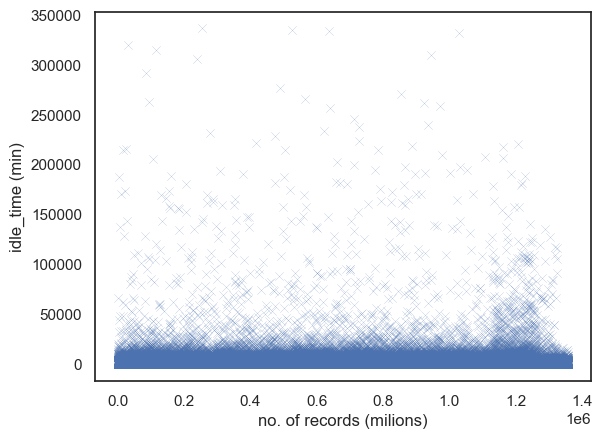

In [56]:
#plotting every record of idle_time 
y=san_fran_df['idle_time'].dt.total_seconds() / 60.0
x=np.arange(len(y))
plt.scatter(x,y, marker='x', linewidths=0.1)
plt.xlabel('no. of records (milions)')
plt.ylabel('idle_time (min)')
plt.show()

### Understanding the relationship between idle_time and station_distance

We are testing if there is a relation between the station_distance (=the air distance between the start and end stations of the trip) and the idle_time of a bike.

In [57]:
feature_selection('station_distance')

F-scores: [97.35804175]
p-values: [5.79621568e-23]


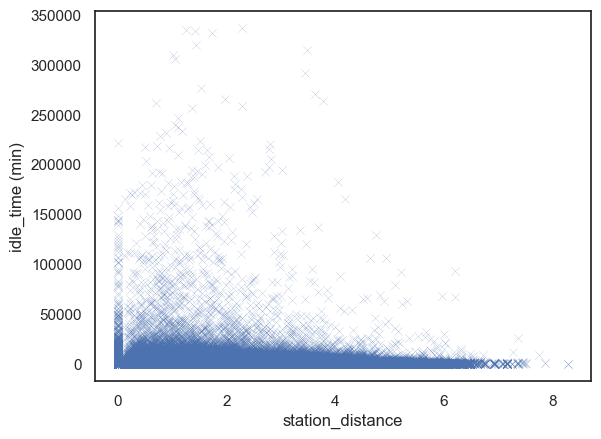

In [58]:
relation_to_idle_time('station_distance')

Text(0, 0.5, 'number of trips')

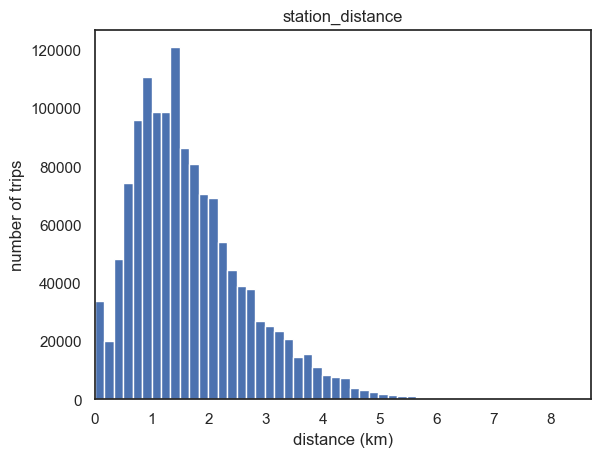

In [59]:
x = san_fran_df['station_distance']
plt.hist(x, bins=50)
plt.xlim(left=0)  # Set the lower and upper limits for the x-axis
plt.title('station_distance')
plt.xlabel('distance (km)')
plt.ylabel('number of trips')

While there may be some correlation between the idle_time and the station_distance the trends are not that visible therefore we will not use this feature for the prediction of idle_time.

### Understanding the relationship between idle_time and trip_duration


In [60]:
feature_selection('trip_duration')

F-scores: [241.5762833]
p-values: [1.80180311e-54]


In [61]:
x = san_fran_df['trip_duration'].dt.total_seconds() / 60.0
y = san_fran_df['idle_time'].dt.total_seconds() / 60.0

In [62]:
san_fran_df['trip_duration'].mean()

Timedelta('0 days 00:14:39.250198545')

Text(0, 0.5, 'idle_time (min)')

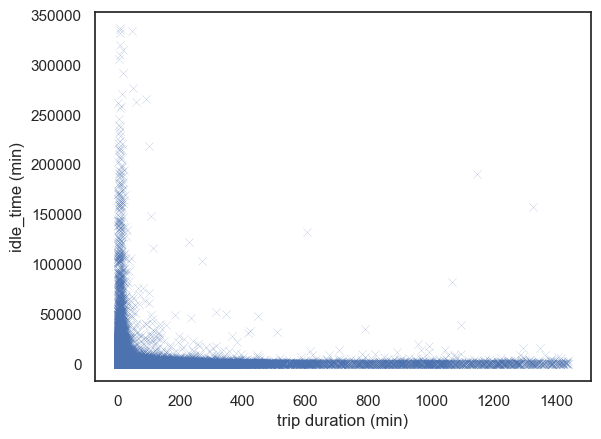

In [63]:
plt.scatter(x, y, marker='x', linewidths=0.1)
plt.xlabel('trip duration (min)')
plt.ylabel('idle_time (min)')

This shows that the feature is not significant for the prediction of idle_time.

### Understanding the relationship between idle_time and end_temperature

In [65]:
feature_selection('end_temperature')

F-scores: [12.82399387]
p-values: [0.00034221]


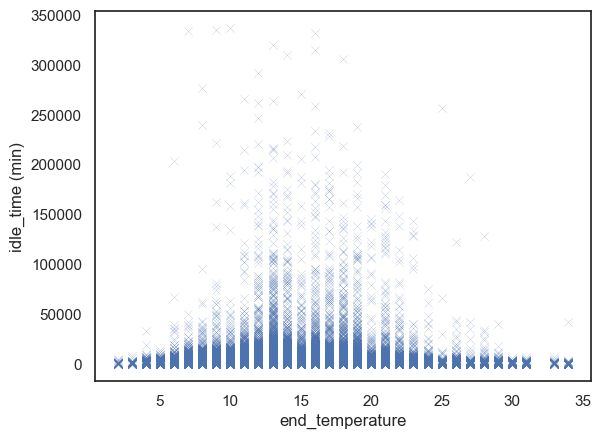

In [67]:
relation_to_idle_time('end_temperature')

End temperature could be a good candidate for a predictor feature.

### Understanding the relationship between idle_time and Weekday

We want to test if the length of idle_time is dependent on the day of the week when the bike is dropped off. 

In [68]:
feature_selection('Weekday')

F-scores: [1570.621303]
p-values: [0.]


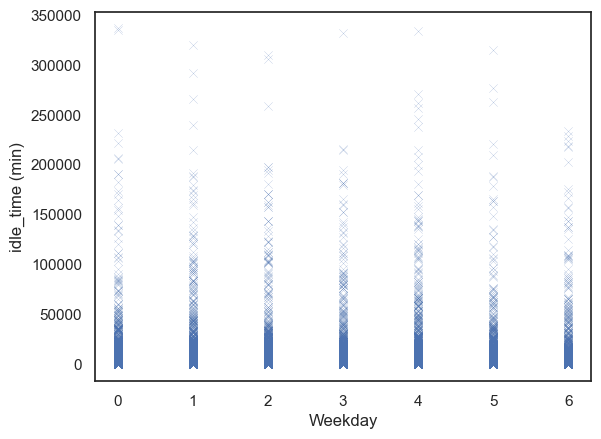

In [69]:
relation_to_idle_time('Weekday')

This shows big connection.

### Understanding the relationship between idle_time and Is_Weekend

In [70]:
feature_selection('Is_Weekend')

F-scores: [1337.22063846]
p-values: [1.28123447e-292]


Let's also try Weekday:

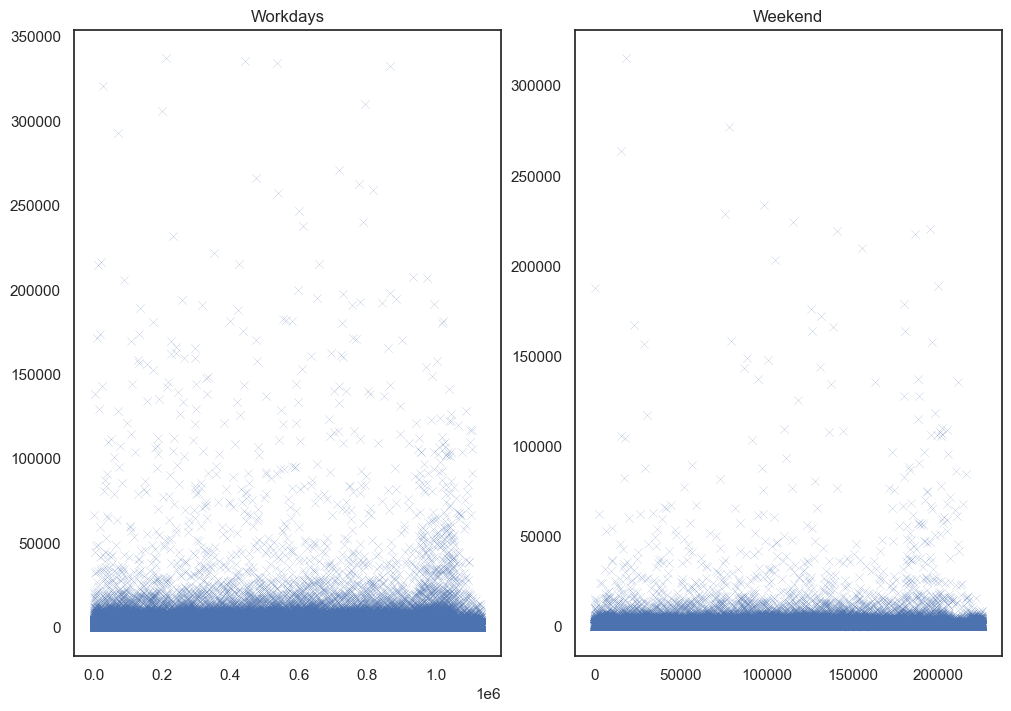

In [72]:
#plot the differences between idle_time and workday x weekend
y_1 = san_fran_df[san_fran_df['Is_Weekend'] == 0]['idle_time'].dt.total_seconds()/60
x_1 = np.arange(len(y_1))
y_2 = san_fran_df[san_fran_df['Is_Weekend'] == 1]['idle_time'].dt.total_seconds() /60
x_2 = np.arange(len(y_2))

fig, axs = plt.subplots(1,2, figsize=(10,7),constrained_layout=True)
axs[0].scatter(x_1,y_1, marker='x', linewidths=0.1)
axs[0].set_title('Workdays')
axs[1].scatter(x_2,y_2, marker='x', linewidths=0.1)
axs[1].set_title('Weekend')
plt.show()

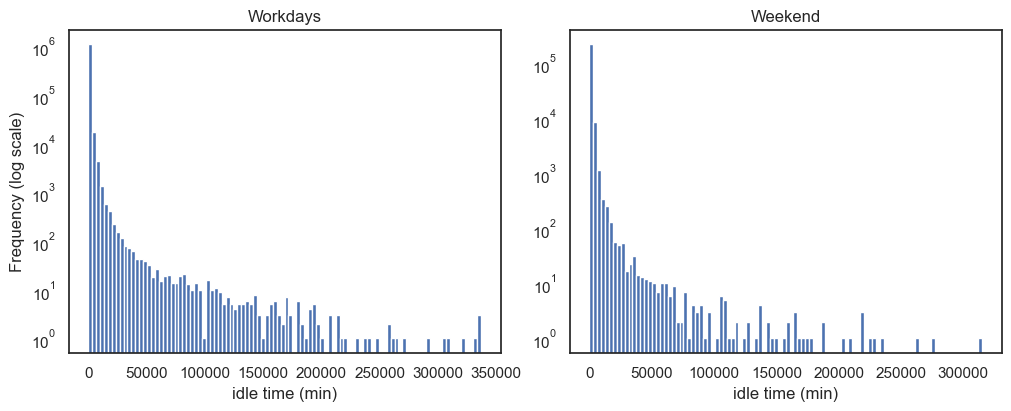

In [73]:
y_1 = san_fran_df[san_fran_df['Is_Weekend'] == 0]['idle_time'].dt.total_seconds()/60
x_1 = np.arange(len(y_1))
y_2 = san_fran_df[san_fran_df['Is_Weekend'] == 1]['idle_time'].dt.total_seconds() /60
x_2 = np.arange(len(y_2))
fig, axs = plt.subplots(1,2, figsize=(10,4),constrained_layout=True)
axs[0].hist(y_1, bins=100,log=True)
axs[0].set_title('Workdays')
axs[0].set_ylabel('Frequency (log scale)')
axs[0].set_xlabel('idle time (min)')
axs[1].hist(y_2, bins=100,log=True)
axs[1].set_title('Weekend')
axs[1].set_xlabel('idle time (min)')
plt.show()

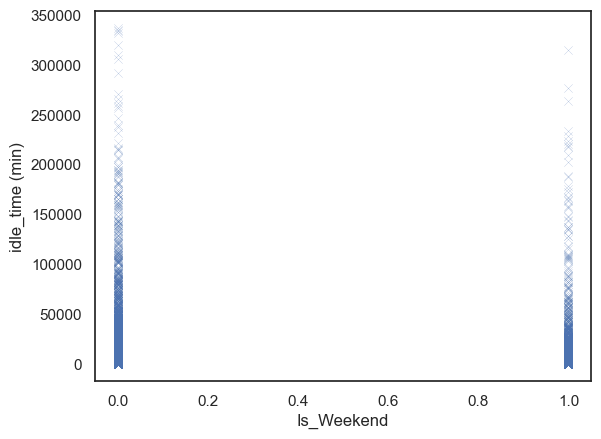

In [74]:
relation_to_idle_time('Is_Weekend')

We can see that idle_time is on average lower during the weekend.

### Understanding the relationship between idle_time and rain_start

In [75]:
feature_selection('rain_start')

F-scores: [10.01976188]
p-values: [0.00154873]


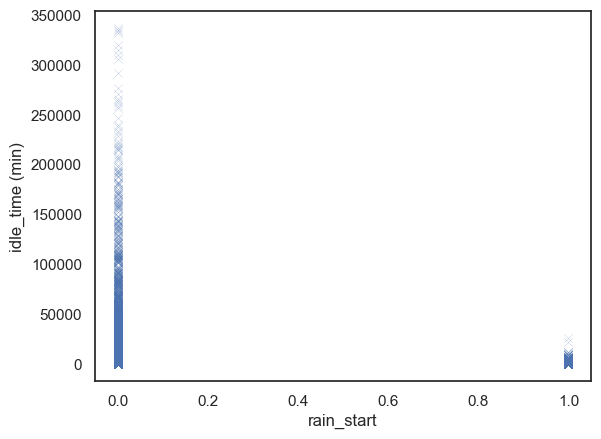

In [76]:
relation_to_idle_time('rain_start')

### Understanding the relationship between idle_time and start_precipitation

In [77]:
feature_selection('start_precipitation')

F-scores: [12.47191765]
p-values: [0.00041313]


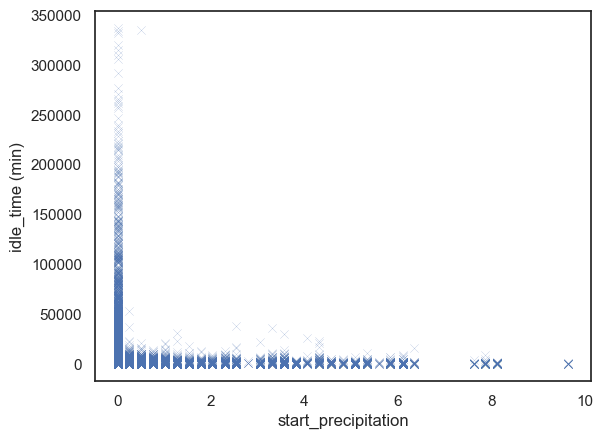

In [78]:
relation_to_idle_time('start_precipitation')

It seems that precipitation is not good predictor for the idle_time in San Francisco

### Understanding the relationship between idle_time and end_station_central_station_dist

In [80]:
feature_selection('end_station_central_station_dist')

F-scores: [433.04037214]
p-values: [3.66601689e-96]


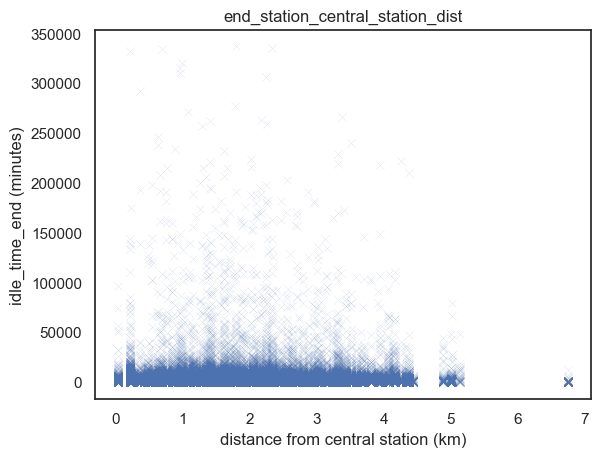

In [83]:
x= san_fran_df['end_station_central_station_dist']
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.scatter(x,y, marker='x', linewidths=0.05)
plt.title('end_station_central_station_dist')
plt.xlabel('distance from central station (km)')
plt.ylabel('idle_time_end (minutes)')

plt.show()

Text(0, 0.5, 'number of trips')

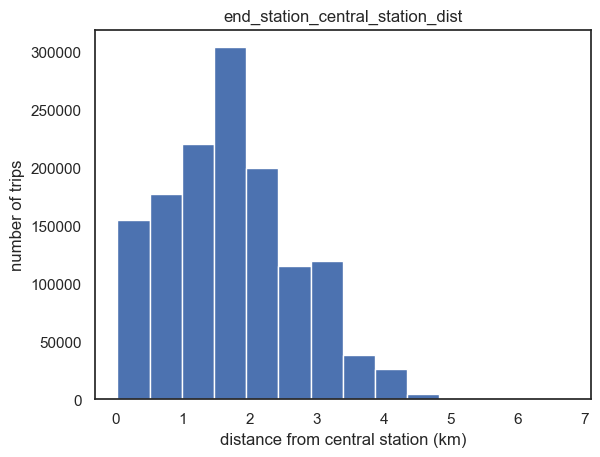

In [85]:
#check the distribution of the start_station_central_station_dist
x= san_fran_df['end_station_central_station_dist']
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.hist(x, bins=14)
plt.title('end_station_central_station_dist')
plt.xlabel('distance from central station (km)')
plt.ylabel('number of trips')

In [88]:
"""
#try to plot it using the distance to mean and median
data = san_fran_df['idle_time']
mean_raw = data.mean()
mean = data.mean().total_seconds() / 60.0
centered_data_mean = data.dt.total_seconds() / 60.0 - mean
median_raw = data.median()
median = data.median().total_seconds()/60.0
centered_data_median = data.dt.total_seconds() / 60.0 - median
print("mean in timedelata dtype:",mean_raw)
print("mean in minutes:",mean)
print("median in timedelata dtype:",median_raw)
print("median in minutes:",median)

print(centered_data_mean)
"""

'\n#try to plot it using the distance to mean and median\ndata = san_fran_df[\'idle_time\']\nmean_raw = data.mean()\nmean = data.mean().total_seconds() / 60.0\ncentered_data_mean = data.dt.total_seconds() / 60.0 - mean\nmedian_raw = data.median()\nmedian = data.median().total_seconds()/60.0\ncentered_data_median = data.dt.total_seconds() / 60.0 - median\nprint("mean in timedelata dtype:",mean_raw)\nprint("mean in minutes:",mean)\nprint("median in timedelata dtype:",median_raw)\nprint("median in minutes:",median)\n\nprint(centered_data_mean)\n'

In [89]:
"""
#plot the centered_data_mean distribution
x= san_fran_df['start_station_central_station_dist']
y_centered = centered_data_mean
plt.scatter(x,y_centered, marker='x', linewidths=0.1)
plt.axhline(566.5028563833333, color="orange", label="mean")
plt.axhline(0, color="black", label="zero")
plt.title('start_station_central_station_dist')
plt.xlabel('distance from central station (km)')
plt.ylabel('iidle_time: distance from mean (min)')
plt.legend()
"""

'\n#plot the centered_data_mean distribution\nx= san_fran_df[\'start_station_central_station_dist\']\ny_centered = centered_data_mean\nplt.scatter(x,y_centered, marker=\'x\', linewidths=0.1)\nplt.axhline(566.5028563833333, color="orange", label="mean")\nplt.axhline(0, color="black", label="zero")\nplt.title(\'start_station_central_station_dist\')\nplt.xlabel(\'distance from central station (km)\')\nplt.ylabel(\'iidle_time: distance from mean (min)\')\nplt.legend()\n'

In [90]:
"""
#show idle_time distance from mean < 40000
plt.scatter(x,y_centered, marker='x', linewidths=0.1)
plt.axhline(566.5028563833333, color="orange", label="mean")
plt.axhline(0, color="black", label="zero")
plt.title('start_station_central_station_dist')
plt.xlabel('distance from central station (km)')
plt.ylabel('idle_time: distance from mean (min)')
plt.legend()
"""

'\n#show idle_time distance from mean < 40000\nplt.scatter(x,y_centered, marker=\'x\', linewidths=0.1)\nplt.axhline(566.5028563833333, color="orange", label="mean")\nplt.axhline(0, color="black", label="zero")\nplt.title(\'start_station_central_station_dist\')\nplt.xlabel(\'distance from central station (km)\')\nplt.ylabel(\'idle_time: distance from mean (min)\')\nplt.legend()\n'

### Understanding the relationship between idle_time and start_station_ferry_building_dist

In [92]:
feature_selection('end_station_ferry_building_dist')

F-scores: [2038.35558678]
p-values: [0.]


The high F-score indicates a very strong correlation with idle_time.

Text(0, 0.5, 'idle_time (minutes)')

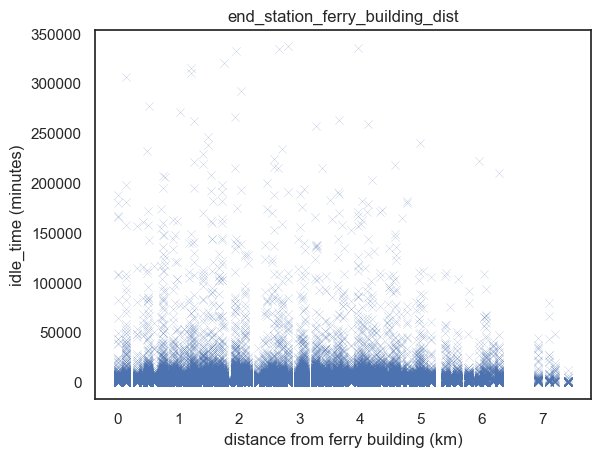

In [94]:
x= san_fran_df['end_station_ferry_building_dist']
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.scatter(x,y, marker='x', linewidths=0.1)
plt.title('end_station_ferry_building_dist')
plt.xlabel('distance from ferry building (km)')
plt.ylabel('idle_time (minutes)')

Text(0, 0.5, 'number of trips')

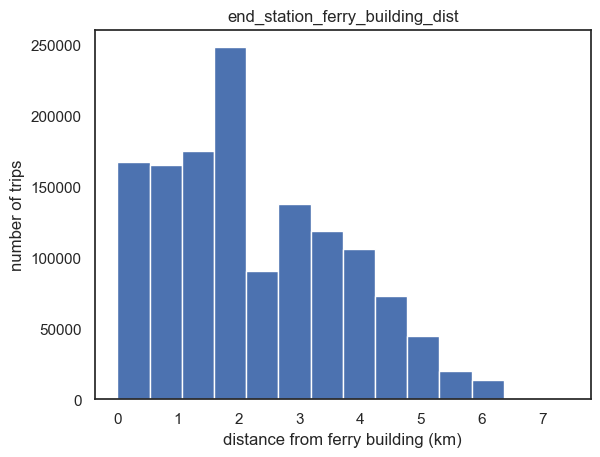

In [95]:
#check the distribution of the start_station_central_station_dist
x= san_fran_df['end_station_ferry_building_dist']
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.hist(x, bins=14)
plt.title('end_station_ferry_building_dist')
plt.xlabel('distance from ferry building (km)')
plt.ylabel('number of trips')

In [96]:
"""
#plot the centered_data distribution
x= san_fran_df['start_station_ferry_building_dist']
y_centered = centered_data_mean
plt.scatter(x,y_centered, marker='x', linewidths=0.1)
plt.axhline(566.5028563833333, color="orange", label="mean")
plt.axhline(0, color="black", label="zero")
plt.title('start_station_ferry_building_dist')
plt.xlabel('distance from ferry building (km)')
plt.ylabel('iidle_time: distance from mean (min)')
plt.legend()
#plt.ylim(-20000)
"""

'\n#plot the centered_data distribution\nx= san_fran_df[\'start_station_ferry_building_dist\']\ny_centered = centered_data_mean\nplt.scatter(x,y_centered, marker=\'x\', linewidths=0.1)\nplt.axhline(566.5028563833333, color="orange", label="mean")\nplt.axhline(0, color="black", label="zero")\nplt.title(\'start_station_ferry_building_dist\')\nplt.xlabel(\'distance from ferry building (km)\')\nplt.ylabel(\'iidle_time: distance from mean (min)\')\nplt.legend()\n#plt.ylim(-20000)\n'

In [97]:
"""
plt.scatter(x,y_centered, marker='x', linewidths=0.1)
plt.axhline(566.5028563833333, color="orange", label="mean")
plt.axhline(0, color="black", label="zero")
plt.title('start_station_ferry_building_dist')
plt.xlabel('distance from ferry building (km)')
plt.ylabel('iidle_time: distance from mean (min)')
plt.legend()
#plt.ylim(-1000, 40000)
"""

'\nplt.scatter(x,y_centered, marker=\'x\', linewidths=0.1)\nplt.axhline(566.5028563833333, color="orange", label="mean")\nplt.axhline(0, color="black", label="zero")\nplt.title(\'start_station_ferry_building_dist\')\nplt.xlabel(\'distance from ferry building (km)\')\nplt.ylabel(\'iidle_time: distance from mean (min)\')\nplt.legend()\n#plt.ylim(-1000, 40000)\n'

### start_station_twitter_HQ_dist

In [99]:
feature_selection('end_station_twitter_HQ_dist')

F-scores: [1.82151187]
p-values: [0.17713365]


This shows that there is no big correlation between **idle_time** and the **start_station_twitter_HQ_dist**

In [102]:
"""
x= san_fran_df['end_station_twitter_HQ_dist']
y_centered = centered_data_mean
plt.scatter(x,y_centered, marker='x', linewidths=0.1)
plt.axhline(566.5028563833333, color="orange", label="mean")
plt.axhline(0, color="black", label="zero")
plt.title('end_station_twitter_HQ_dist')
plt.xlabel('distance from twitter_HQ (km)')
plt.ylabel('idle_time: distance from mean (min)')
plt.legend()
#plt.ylim(-20000)
"""

'\nx= san_fran_df[\'end_station_twitter_HQ_dist\']\ny_centered = centered_data_mean\nplt.scatter(x,y_centered, marker=\'x\', linewidths=0.1)\nplt.axhline(566.5028563833333, color="orange", label="mean")\nplt.axhline(0, color="black", label="zero")\nplt.title(\'end_station_twitter_HQ_dist\')\nplt.xlabel(\'distance from twitter_HQ (km)\')\nplt.ylabel(\'idle_time: distance from mean (min)\')\nplt.legend()\n#plt.ylim(-20000)\n'

Text(0, 0.5, 'number of trips')

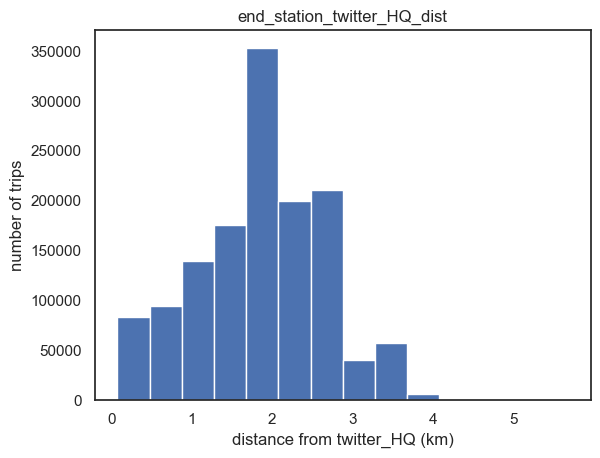

In [104]:
x= san_fran_df['end_station_twitter_HQ_dist']
plt.hist(x, bins=14)
plt.title('end_station_twitter_HQ_dist')
plt.xlabel('distance from twitter_HQ (km)')
plt.ylabel('number of trips')

### Understanding the relationship between idle_time and start_felt_temperature

In [105]:
feature_selection('start_felt_temperature')

F-scores: [45.70474398]
p-values: [1.37544492e-11]


The F-score of start_felt_temperature is a little better than the start_temperature.

Text(0, 0.5, 'idle_time /minutes')

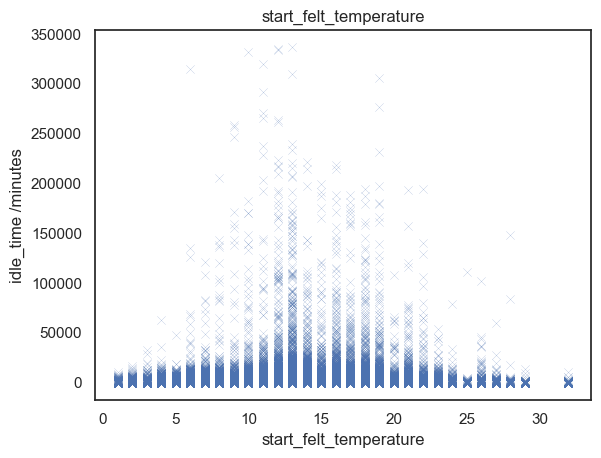

In [74]:
#plotting the start_felt_temperature and idle_time to examine the values
x= san_fran_df['start_felt_temperature']
y_1= san_fran_df['idle_time'].dt.total_seconds() / 60.0
fig,ax = plt.subplots()
ax.scatter(x,y_1, marker='x', linewidths=0.1)
ax.set_title('start_felt_temperature')
ax.set_xlabel('start_felt_temperature')
ax.set_ylabel('idle_time /minutes')


This shows that there apears to be longer idle times when the temperatures are between 10 and 20 degrees Celsius. Let's investigate what may be the reason.

We check the distribution of the start_felt_temperature.

Text(0, 0.5, 'number of trips')

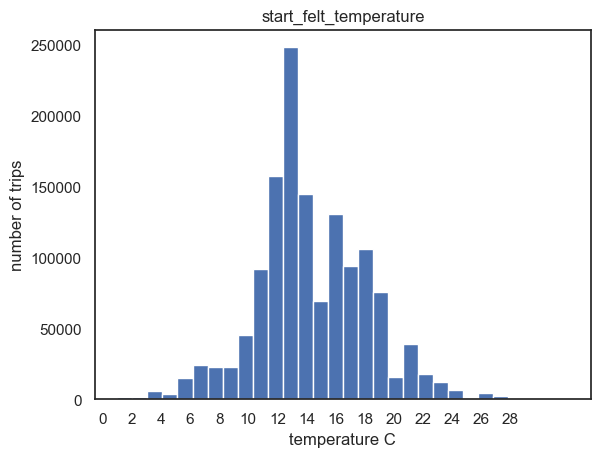

In [75]:
#check the distribution of the start_felt_temperature
x= san_fran_df['start_felt_temperature']
plt.hist(x, bins=30)
plt.xticks(np.arange(0,30,2))
plt.title('start_felt_temperature')
plt.xlabel('temperature C')
plt.ylabel('number of trips')

This shows that in the same temperature window 10-20 Celsius the number of trips are also the largest.

We now look at the trip duration to confirm the assumption that in the temperature window 10-20 Celsius people make more trips that take more time because they are enjoying the mild weather.

Text(0, 0.5, 'trip_duration (min)')

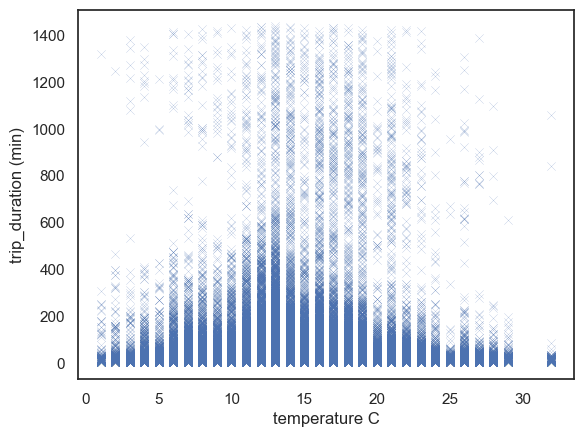

In [76]:
#we now have a look at the relation ship between trip_duration and start_felt_temperature
y = san_fran_df['trip_duration'].dt.total_seconds()/60.0
x = san_fran_df['start_felt_temperature']

plt.scatter(x,y, marker='x', linewidths=0.1)
plt.xlabel('temperature C')
plt.ylabel('trip_duration (min)')

The above graph confirms our hypothesis that people indeed make longer trips in the 10-20 Celsius temperature window.

To understand why the idle time of bikes, the trip duration and number of trips are larger when the temperature is between 10 and 20 degrees Celsius, we can look at the distributions of the start_felt_temperature variable and look at the relationship between start_time and start_felt_temperature variables.  

One of the reasons for a larger idle_time is that with more usage of the bikes the probability that the bike will break down/get lost/get stolen is higher, which leads to the bikes not beeing used and racking up long amounts of idle time, such as 200+ days in extreme situations.

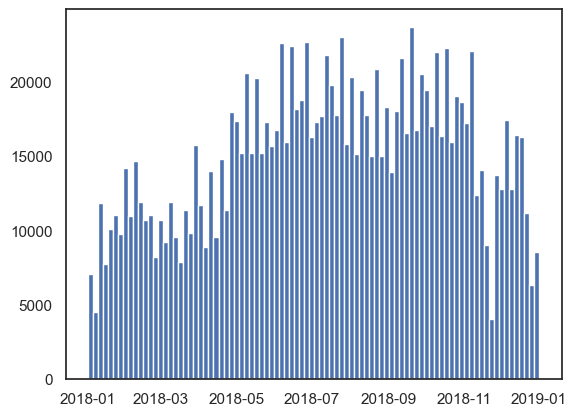

In [77]:
#look at the number of trips in relation to start_time
x_time=san_fran_df['end_time']
x_temperature=san_fran_df['start_felt_temperature']

plt.hist(x_time, bins=90)
plt.show()

We now examine the relation between numbers of trips and the temperature.

In [78]:
#have a look at the values of the start_felt_temperature column
san_fran_df['start_felt_temperature'].describe()

count    1.359874e+06
mean     1.438938e+01
std      3.716500e+00
min      1.000000e+00
25%      1.200000e+01
50%      1.400000e+01
75%      1.700000e+01
max      3.200000e+01
Name: start_felt_temperature, dtype: float64

The average felt temperature is 14.3 degrees and the majority (more than half) of the values is in the (10, 15) interval, more than 75% of the all trips have been made in the  (10, 20) temperature interval.

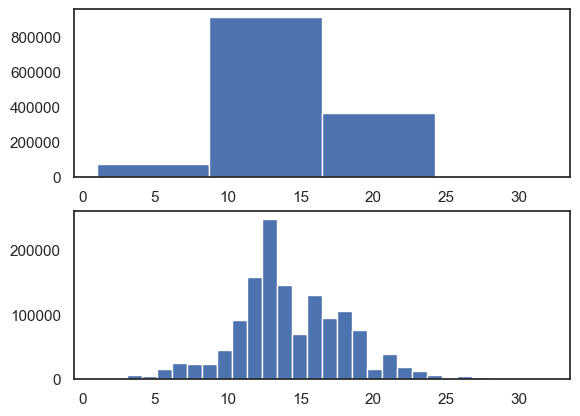

In [79]:
#look at the number of trips in relation to temperature
fig, ax = plt.subplots(2,1)
ax[0].hist(x_temperature, bins=4)
ax[1].hist(x_temperature, bins=30)
plt.show()

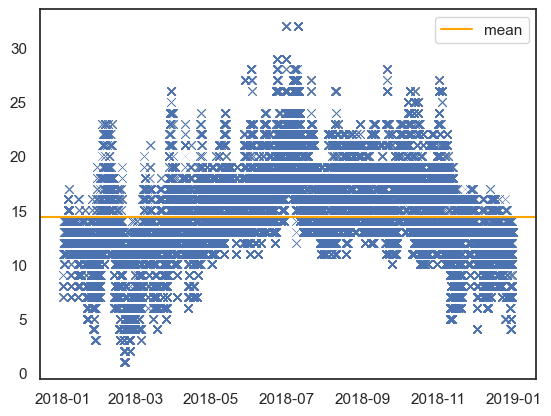

In [80]:
#look at the relation between start_time and start_felt_temperature

plt.scatter(x_time,x_temperature,  marker='x', linewidths=0.1)
plt.axhline(14.38, color='orange', label='mean')
plt.legend()
plt.show()

Thanks to this scatter plot we can now understand why the idle_time of the bikes appears to be, when looking at the scatter plots that display the relationship between the idle_time and start_felt_temperature, the longest in the the (10, 20) temperature interval. 

It is due to the mild weather climate that the most trips are made during this temperature interval hence there is also large idle_time.

In the more extreme temperatures the idle_time is lower due to the fact that the bikes are actually not beeing rented out, therefore the idle_time is just racking up without beeing recorded. The idle_time is recorded only when a new trip is started, which happens understandibly when the weather is nice, in our case between 10 and 20 degrees.

(-3000.0, 60000.0)

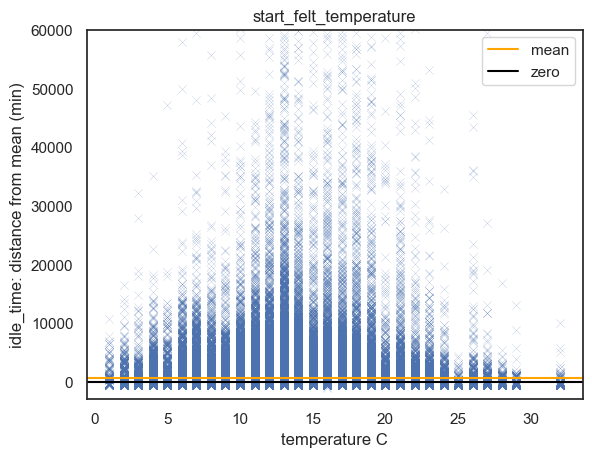

In [81]:
x=san_fran_df['start_felt_temperature']
plt.scatter(x,y_centered, marker='x', linewidths=0.1)
plt.axhline(566.5028563833333, color="orange", label="mean")
plt.axhline(0, color="black", label="zero")
plt.title('start_felt_temperature')
plt.xlabel('temperature C')
plt.ylabel('idle_time: distance from mean (min)')
plt.legend()
plt.ylim(-3000, 60000)

### end_felt_temperature

In [82]:
feature_selection('end_felt_temperature')

F-scores: [3115.83887915]
p-values: [0.]


end_felt_temperature is a better predictor for idle_time than start_felt_temperature, it makes sense due to the nature of the idle time, where it naturally depends more on the temperature at the end of the ride, rather than at the beginning

Text(0, 0.5, 'idle_time /minutes')

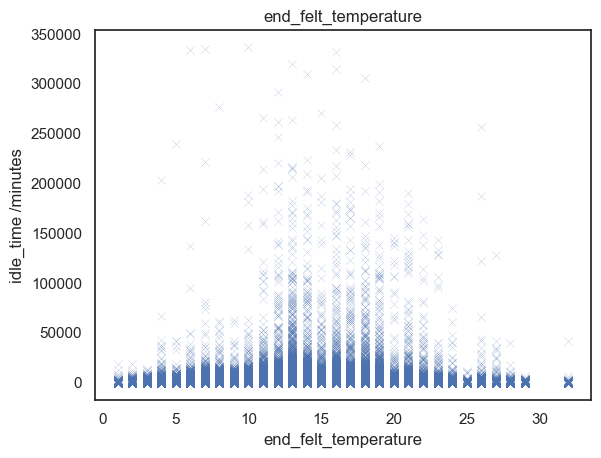

In [83]:
x= san_fran_df['end_felt_temperature']
y= san_fran_df['idle_time_end'].dt.total_seconds() / 60.0
plt.scatter(x,y, marker='x', linewidths=0.1)
plt.title('end_felt_temperature')
plt.xlabel('end_felt_temperature')
plt.ylabel('idle_time /minutes')

Text(0, 0.5, 'number of trips')

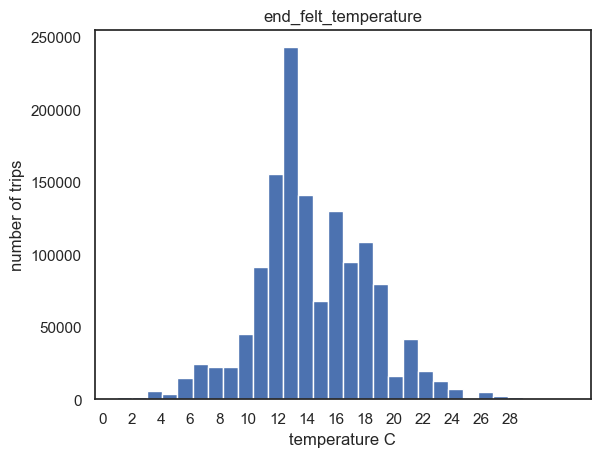

In [84]:
#check the distribution of the start_felt_temperature
x= san_fran_df['end_felt_temperature']
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.hist(x, bins=30)
plt.xticks(np.arange(0,30,2))
plt.title('end_felt_temperature')
plt.xlabel('temperature C')
plt.ylabel('number of trips')

   We can also at the Is_Weekend column

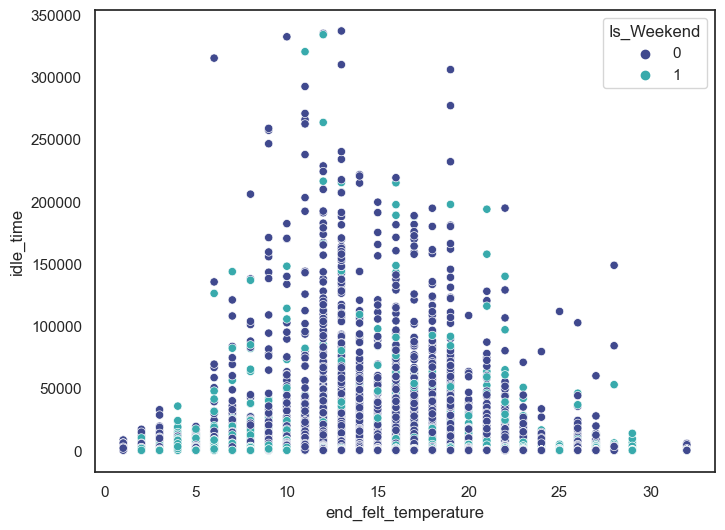

In [85]:
plt.figure(figsize = (8,6))
y = san_fran_df['idle_time'].dt.total_seconds()/60
x = san_fran_df['end_felt_temperature']
sns.scatterplot(x=san_fran_df['end_felt_temperature'], y=san_fran_df['idle_time'].dt.total_seconds()/60,hue=san_fran_df["Is_Weekend"], palette="mako")
plt.show()

### start_cloud_cover

In [86]:
feature_selection('start_cloud_cover')

F-scores: [420.00843049]
p-values: [2.51049799e-93]


start_cloud_cover is not a good predictor of idle_time

## Using the SelectKBest class from sklearn

In [108]:
#try to choose the best feature for predicting of idle_time by using the selectKBest class from sklearn
from sklearn.feature_selection import SelectKBest
x = san_fran_df[['end_station_id', 'start_temperature', 'end_temperature',
                 'start_cloud_cover', 'end_cloud_cover',
                 'start_pressure', 'end_pressure', 'start_windspeed', 'end_windspeed', 'start_precipitation', 
                 'end_precipitation', 'start_felt_temperature', 'end_felt_temperature', 'Weekday', 'Is_Weekend',
                 'temperature_dif','rain_start', 'station_distance', 'end_station_central_station_dist',
                 'end_station_ferry_building_dist', 'end_station_twitter_HQ_dist']]
y = san_fran_df['idle_time'].dt.total_seconds() / 60.0
print("Feature data dimension:", x.shape)
select = SelectKBest(score_func=f_regression, k=10)
x_selected = select.fit_transform(x,y)
print("After selecting best 10 features:", x_selected.shape) 

Feature data dimension: (1359892, 21)
After selecting best 10 features: (1359892, 10)


In [109]:
selected_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_features = [x.columns[idx] for idx in selected_indices]
selected_values = pd.DataFrame(x_selected, columns=selected_features)
selected_scores = select.scores_[selected_indices]
selected_feature_scores = pd.DataFrame({"Feature": selected_features, "Score": selected_scores})
print("Selected features with scores:")
print(selected_feature_scores)


Selected features with scores:
                            Feature        Score
0                    end_station_id   671.377670
1                 start_cloud_cover   199.359241
2                   end_cloud_cover   192.036272
3                    start_pressure   949.600312
4                      end_pressure   944.230880
5                           Weekday  1570.621303
6                        Is_Weekend  1337.220638
7                  station_distance    97.358042
8  end_station_central_station_dist   433.040372
9   end_station_ferry_building_dist  2038.355587


The SelectKBest class form sklearn show us that the features with the biggest correlation with idle_time are the distance to the point of interest that we have chosen using the visual map exploration of the stations and their respective numbers of interactions. For the prediction model we will use the distance  **end_station_ferry_building_dist** and the **Weekday/Is_Weekend** features.

## Building the prediction models:

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# 1) Linear regression

We will try to use distance to the mean for the end_felt_temperature

mean: 14.471866511162064
median: 111.21666666666667
0         -2.471867
1         -0.471867
2         -2.471867
3         -2.471867
4         -2.471867
             ...   
1359869   -1.471867
1359870   -1.471867
1359871   -1.471867
1359872   -1.471867
1359873   -1.471867
Name: end_felt_temperature, Length: 1359874, dtype: float64


(0.0, 30000.0)

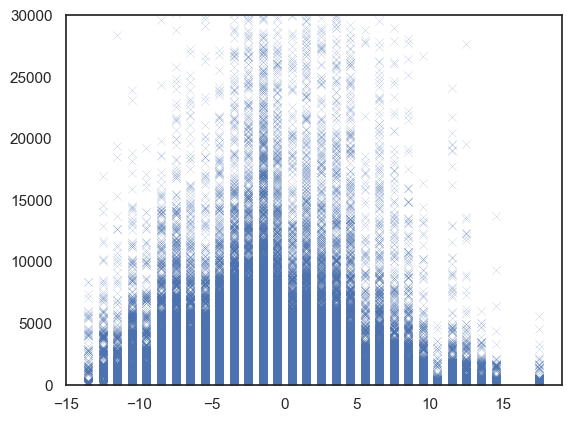

In [90]:
data = san_fran_df['end_felt_temperature']
mean = data.mean()
centered_end_felt_temperature = data - mean

print("mean:",mean)
print("median:",median)
print(centered_end_felt_temperature)
mean=san_fran_df['end_felt_temperature'].mean()
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.scatter(centered_end_felt_temperature,y, marker='x', linewidths=0.1)
plt.ylim(0,30000)

In [91]:
X=centered_end_felt_temperature.values.reshape(-1,1)
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)
#X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)


In [93]:
# Create and fit the linear regression model
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predict idle time using the trained model
y_predicted_valid = model1.predict(X_valid)
xNew = np.array([-5])
yNew = model1.predict(xNew.reshape(1, -1))
# Print the coefficients and intercept of the model
print("Coefficients:", model1.coef_)
print("Intercept:", model1.intercept_)
print("Idle_time (min):",yNew)

Coefficients: [-35.79350531]
Intercept: 566.7982662034406
Idle_time (min): [745.76579277]


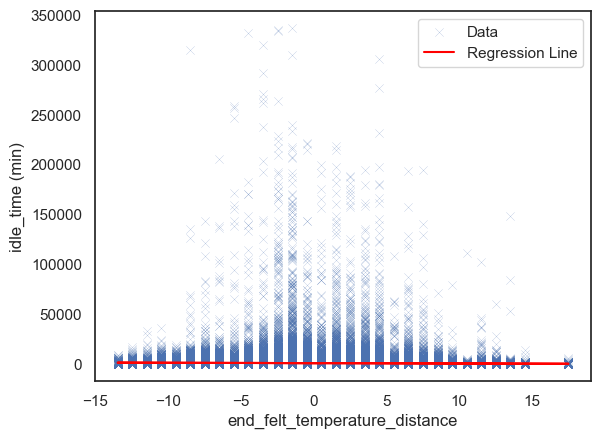

In [94]:
plt.scatter(X, y, marker='x', linewidths=0.1, label='Data')
plt.plot(X_valid, y_predicted_valid, color='red', label='Regression Line')
plt.xlabel('end_felt_temperature_distance')
plt.ylabel('idle_time (min)')
plt.legend()
plt.show()

In [95]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid, y_predicted_valid),"minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted_valid)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted_valid)) 

Mean Absolute Error: 650.7499687867046 minutes
Root Mean Squared Error: 2712.3339077070727 minutes
Coefficient of determination: 0.0022677156666820464


This shows that there is high bias towards the large values of idle_time

Trying the distance features

In [96]:
X= san_fran_df['start_station_central_station_dist'].values.reshape(-1,1)
y= san_fran_df['idle_time'].dt.total_seconds() / 60.0
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=2)
# Create and fit the linear regression model
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Predict idle time using the trained model
y_predicted_valid = model2.predict(X_valid)
xNew = np.array([0.1])
yNew = model2.predict(xNew.reshape(1, -1))
# Print the coefficients and intercept of the model
print("Coefficients:", model2.coef_)
print("Intercept:", model2.intercept_)
print("Idle_time (min):",yNew)

Coefficients: [170.44620564]
Intercept: 258.6294170522608
Idle_time (min): [275.67403762]


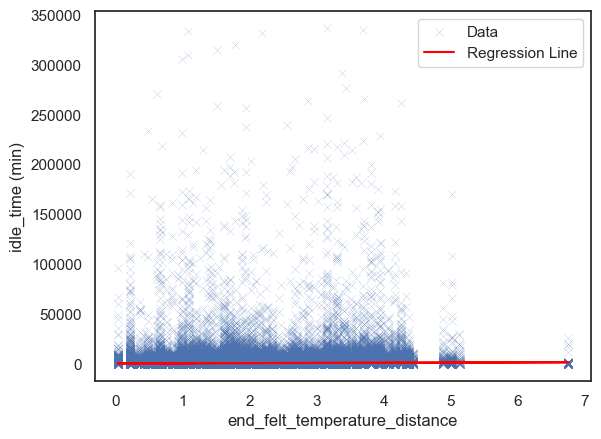

In [97]:
plt.scatter(X, y, marker='x', linewidths=0.1, label='Data')
plt.plot(X_valid, y_predicted_valid, color='red', label='Regression Line')
plt.xlabel('start_station_central_station_dist')
plt.ylabel('idle_time (min)')
plt.legend()
plt.show()

In [98]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid, y_predicted_valid),"minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted_valid)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted_valid)) 

Mean Absolute Error: 653.0718379672362 minutes
Root Mean Squared Error: 2710.1163906019337 minutes
Coefficient of determination: 0.003898476518682581


We are considering dropping all idle_time value above 30000 minutes.

## Reducing the variability of our records
We will investigate if reducing the sample to the rows that have an idle_time that is the result of normal usage is possible.

In [115]:
san_fran_df['idle_time'].describe()

count                      1359874
mean     0 days 09:26:30.171383525
std      1 days 22:13:22.271668154
min              -1 days +15:59:09
25%                0 days 00:23:28
50%                0 days 01:51:13
75%                0 days 09:47:52
max              233 days 22:43:15
Name: idle_time, dtype: object

We can already see that more than 75% of all records have an idle_time lower than 10 hours.

In [168]:
#display the number of rows where idle_time is lower than 24 hours (1440minutes)
reduced_san_fran_df_day = san_fran_df[san_fran_df['idle_time'].dt.total_seconds()/60.0 <= 1440 ]
reduced_san_fran_df_day['idle_time'].describe()

count                      1259226
mean     0 days 04:35:02.733726908
std      0 days 05:58:26.794911343
min              -1 days +15:59:09
25%                0 days 00:20:35
50%                0 days 01:28:15
75%                0 days 07:26:58
max                1 days 00:00:00
Name: idle_time, dtype: object

In [169]:
#display the number of rows where idle_time is lower than 1 week (10080minutes)
reduced_san_fran_df_week = san_fran_df[san_fran_df['idle_time'].dt.total_seconds()/60.0 <= 10080 ]
reduced_san_fran_df_week['idle_time'].describe()

count                      1355243
mean     0 days 07:51:05.992565170
std      0 days 15:11:36.147655087
min              -1 days +15:59:09
25%                0 days 00:23:20
50%                0 days 01:50:03
75%                0 days 09:39:03
max                6 days 23:59:58
Name: idle_time, dtype: object

This shows that only 100000 rows out of 1359874 records (aproximately 7,36%) have an idle_time longer then 1 day.

Our goal is to focus on reliably predicting the idle_time of bikes on a daily basis to support operation managers when to schedule maintenance of bikes or moving them between stations. 

Therefore we will drop the rows where the idle_time is longer than one day under the assumption that longer idle_times of bikes are consequences of 'force majeure', that is when an extraordinary event or circumstance occurs(such as lost/stolen/broken bike).

# 1)linear regression vol2
Doing regression with a sample that has lower variability

We will try to use distance to the mean for the end_felt_temperature

mean: 14.473308476782393
median: 111.21666666666667
0         -2.473308
1         -0.473308
2         -2.473308
3         -2.473308
4         -2.473308
             ...   
1359869   -1.473308
1359870   -1.473308
1359871   -1.473308
1359872   -1.473308
1359873   -1.473308
Name: end_felt_temperature, Length: 1355243, dtype: float64


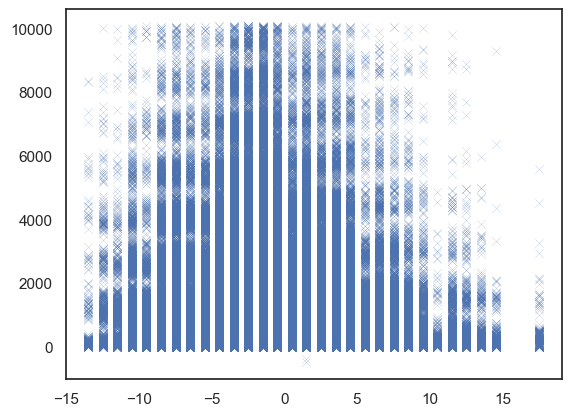

In [106]:
data = reduced_san_fran_df['end_felt_temperature']
mean = data.mean()
centered_end_felt_temperature = data - mean

print("mean:",mean)
print("median:",median)
print(centered_end_felt_temperature)
mean=reduced_san_fran_df['end_felt_temperature'].mean()
y= reduced_san_fran_df['idle_time'].dt.total_seconds() / 60.0
plt.scatter(centered_end_felt_temperature,y, marker='x', linewidths=0.1)

In [107]:
X=centered_end_felt_temperature.values.reshape(-1,1)
y= reduced_san_fran_df['idle_time'].dt.total_seconds() / 60.0

In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=3)
#X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)


In [109]:
# Create and fit the linear regression model
model3 = LinearRegression()
model3.fit(X_train, y_train)

# Predict idle time using the trained model
y_predicted_valid = model3.predict(X_valid)
xNew = np.array([-5])
yNew = model3.predict(xNew.reshape(1, -1))
# Print the coefficients and intercept of the model
print("Coefficients:", model3.coef_)
print("Intercept:", model3.intercept_)
print("Idle_time (min):",yNew)

Coefficients: [-33.42207458]
Intercept: 471.8125715652689
Idle_time (min): [638.92294444]


/Users/davidbrablc/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


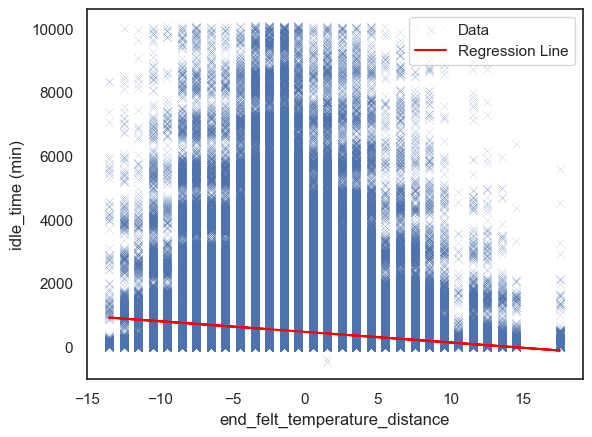

In [110]:
plt.scatter(X, y, marker='x', linewidths=0.1, label='Data')
plt.plot(X_valid, y_predicted_valid, color='red', label='Regression Line')
plt.xlabel('end_felt_temperature_distance')
plt.ylabel('idle_time (min)')
plt.legend()
plt.show()

In [111]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid, y_predicted_valid),"minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted_valid)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted_valid)) 

Mean Absolute Error: 516.3577267325979 minutes
Root Mean Squared Error: 900.4401518927342 minutes
Coefficient of determination: 0.020050931058570032


This shows that there is high bias towards the large values of idle_time

Trying the distance features:

In [112]:
X= reduced_san_fran_df['start_station_central_station_dist'].values.reshape(-1,1)
y= reduced_san_fran_df['idle_time'].dt.total_seconds() / 60.0
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state4)
# Create and fit the linear regression model
model4 = LinearRegression()
model4.fit(X_train, y_train)

# Predict idle time using the trained model
y_predicted_valid = model4.predict(X_valid)
xNew = np.array([0.1])
yNew = model4.predict(xNew.reshape(1, -1))
# Print the coefficients and intercept of the model
print("Coefficients:", model4.coef_)
print("Intercept:", model4.intercept_)
print("Idle_time (min):",yNew)

Coefficients: [121.09085295]
Intercept: 253.14677234390888
Idle_time (min): [265.25585764]


/Users/davidbrablc/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


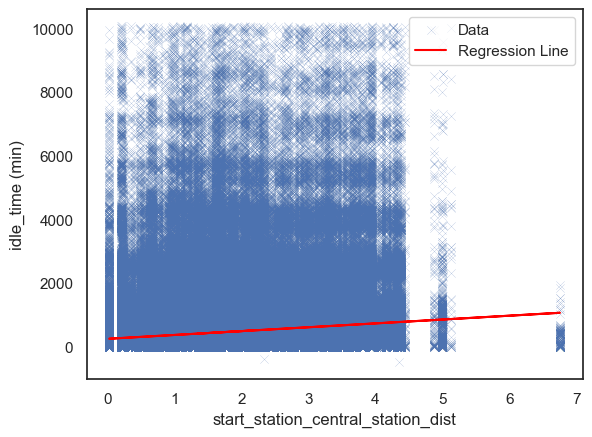

In [113]:
plt.scatter(X, y, marker='x', linewidths=0.1, label='Data')
plt.plot(X_valid, y_predicted_valid, color='red', label='Regression Line')
plt.xlabel('start_station_central_station_dist')
plt.ylabel('idle_time (min)')
plt.legend()
plt.show()

In [114]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid, y_predicted_valid),"minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted_valid)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted_valid)) 

Mean Absolute Error: 518.6046154309266 minutes
Root Mean Squared Error: 901.5901331065888 minutes
Coefficient of determination: 0.017546283454066725


Making a model with three independent features: **start_station_central_station_dist, start_station_ferry_building_dist** and **end_felt_temperature** 

In [147]:
X= reduced_san_fran_df[['start_station_central_station_dist', 'end_felt_temperature', 'start_station_ferry_building_dist']]
y= reduced_san_fran_df['idle_time'].dt.total_seconds() / 60.0
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=5)
m2f = LinearRegression()
m2f.fit(X_train, y_train)


LinearRegression()

In [148]:
y_predicted= m2f.predict(X_valid)

In [149]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid,y_predicted ), "minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted)) 

Mean Absolute Error: 501.6692793582612 minutes
Root Mean Squared Error: 892.1085262939752 minutes
Coefficient of determination: 0.050439228432855865


The Linear Regression model using three features has so far performed the best, but still only with a 5% ability to correctly predict on new unseen data.

Introducing **polynomial features**:


In [165]:
#one feature end_felt_temperature
X=reduced_san_fran_df[['start_station_central_station_dist', 'end_felt_temperature', 'start_station_ferry_building_dist']]
y=reduced_san_fran_df['idle_time'].dt.total_seconds() / 60.0
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=6)
PF = PolynomialFeatures(degree=10)
X_train_poly=PF.fit_transform(X_train)
X_valid_poly=PF.fit_transform(X_valid)
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)
y_predicted_poly = lin_reg_poly.predict(X_valid_poly)

In [166]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid,y_predicted_poly ), "minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted_poly)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted_poly)) 

Mean Absolute Error: 486.7182622676357 minutes
Root Mean Squared Error: 880.416639003999 minutes
Coefficient of determination: 0.07727271818823034


We have reached an R2 score of 7.8% which is still very bad. 

# 2)Random forest regressor

In [134]:
X=centered_end_felt_temperature.values.reshape(-1,1)
y= reduced_san_fran_df['idle_time'].dt.total_seconds() / 60.0
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
ml_forest = RandomForestRegressor(n_estimators=1000, random_state=1)
ml_forest.fit(X_train, y_train)


RandomForestRegressor(n_estimators=1000, random_state=1)

In [135]:
y_predicted = ml_forest.predict(X_valid)

/Users/davidbrablc/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


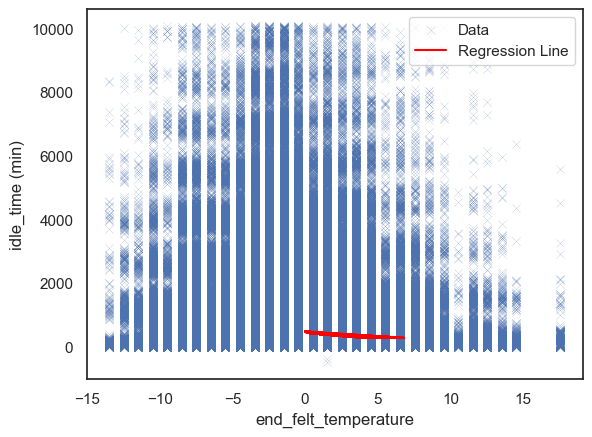

In [129]:
plt.scatter(X, y, marker='x', linewidths=0.1, label='Data')
plt.plot(X_valid, y_predicted, color='red', label='Regression Line')
plt.xlabel('end_felt_temperature')
plt.ylabel('idle_time (min)')
plt.legend()
plt.show()

In [136]:
# present test_metrics
print("Mean Absolute Error:",mean_absolute_error(y_valid,y_predicted ), "minutes")
print("Root Mean Squared Error:",mean_squared_error(y_valid, y_predicted)**0.5,"minutes")
print("Coefficient of determination:",r2_score(y_valid, y_predicted)) 

Mean Absolute Error: 503.26091731150956 minutes
Root Mean Squared Error: 918.8793156093686 minutes
Coefficient of determination: -0.020494692742473397
